In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cap = cv2.VideoCapture('videos/bol.mp4')
scale = 0.3
frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
frame_rate = cap.get(cv2.CAP_PROP_FPS)
print(f'dimensions: {frame_count} frames of ({width}, {height}) at {frame_rate} fps')
print(f'total secs:{frame_count / frame_rate}')


dimensions: 303.0 frames of (1280.0, 720.0) at 30.280855770074254 fps
total secs:10.006322222222222


(288, 512, 3)


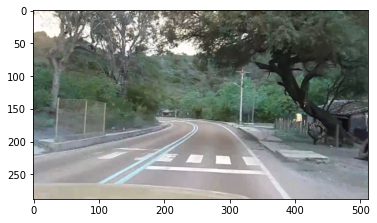

In [4]:
sec = 129.0
scale = 0.4
frame_pos = int(sec * frame_rate)
cap.set(cv2.CAP_PROP_POS_FRAMES, 80)
ret, frame = cap.read()
dim = (int(frame.shape[1] * scale), int(frame.shape[0] * scale))
frame = cv2.resize(frame, dim, interpolation=cv2.INTER_AREA)
print(frame.shape)
plt.imshow(frame)

(288, 512)
(288, 512)


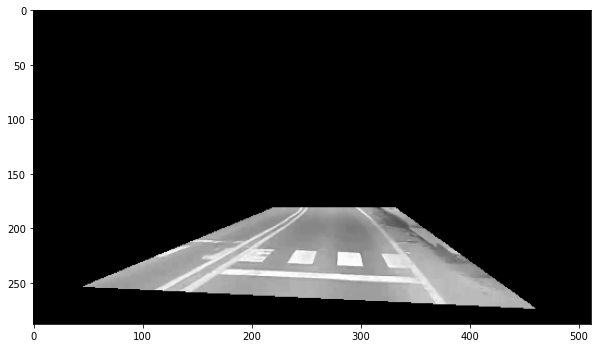

In [5]:
h = frame.shape[0]
w = frame.shape[1]
stencil = np.zeros_like(frame[:,:,0])
print(stencil.shape)
points = [(0.09, 0.88), (0.43, 0.6296), (0.65, 0.6296), (0.9, 0.95)]
polygon = np.array([
        [int(w * 0.09), int(h * 0.88)], 
        [int(w * 0.43), int(h * 0.6296)], 
        [int(w * 0.65), int(h * 0.6296)], 
        [int(w * 0.9), int(h * 0.95)]
    ])

cv2.fillConvexPoly(stencil, polygon, 1)
# apply polygon as a mask on the frame
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
img = cv2.bitwise_and(gray, gray, mask=stencil)
print(img.shape)
# plot masked frame
plt.figure(figsize=(10,10))
plt.imshow(img, cmap= "gray")
plt.show()

In [ ]:
# apply image thresholding
ret, thresh = cv2.threshold(img, 195, 220, cv2.THRESH_BINARY)
print(thresh.shape)
# plot image
plt.figure(figsize=(10,10))
plt.imshow(thresh, cmap= "gray")
plt.show()

In [ ]:
eroded = cv2.erode(thresh, np.ones((3,3), np.uint8), iterations=1)
plt.figure(figsize=(10,10))
plt.imshow(eroded, cmap= "gray")
plt.show()

In [ ]:
dilated = cv2.dilate(eroded, np.ones((3,3), np.uint8), iterations=2)
plt.figure(figsize=(10,10))
plt.imshow(dilated, cmap= "gray")
plt.show()

In [ ]:
# apply image thresholding
# ret, thresh = cv2.threshold(img, 110, 145, cv2.THRESH_BINARY)
edges = cv2.Canny(dilated, 50, 150, apertureSize=3)
# plot image
plt.figure(figsize=(10,10))
plt.imshow(edges, cmap= "gray")
plt.show()

In [ ]:
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 27, maxLineGap=170)

# create a copy of the original frame
dmy = frame.copy()

# draw Hough lines
for line in lines:
  x1, y1, x2, y2 = line[0]
  cv2.line(dmy, (x1, y1), (x2, y2), (255, 0, 0), 1)

# plot frame
plt.figure(figsize=(10,10))
plt.imshow(dmy, cmap= "gray")
plt.show()

In [7]:

def get_zebra(frame, poly_points, brightness_low, brightness_high):
    h = frame.shape[0]
    w = frame.shape[1]
    # print(f'frame: ({w}, {h})')
    stencil = np.zeros_like(frame[:,:,0])
    # polygon = np.array([
    #     [int(w * 0.1042), h], 
    #     [int(w * 0.4167), int(h * 0.6296)], 
    #     [int(w * 0.7917), int(h * 0.6296)], 
    #     [w, h]
    # ])
    polygon = np.array([
        [int(w * poly_points[0][0]), int(h * poly_points[0][1])], 
        [int(w * poly_points[1][0]), int(h * poly_points[1][1])],
        [int(w * poly_points[2][0]), int(h * poly_points[2][1])],
        [int(w * poly_points[3][0]), int(h * poly_points[3][1])]
    ])
    cv2.fillConvexPoly(stencil, polygon, 1)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    img = cv2.bitwise_and(gray, gray, mask=stencil)
    # apply image thresholding       120, 145
    ret, thresh = cv2.threshold(img, brightness_low, brightness_high, cv2.THRESH_BINARY)
    eroded = cv2.erode(thresh, np.ones((3,3), np.uint8), iterations=1)
    dilated = cv2.dilate(eroded, np.ones((3,3), np.uint8), iterations=2)
    edges = cv2.Canny(dilated, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, int(w * 0.0833), maxLineGap=int(w * 0.4167))
    # print(lines)
    # print(f'lines: {lines.shape}, \n{lines}')
    if lines is None:
        # print('no zebra detected')
        return []
    lines = np.reshape(lines, (-1, 4))
    rhos = np.array([np.sqrt((x2 - x1)**2 + (y2 - y1)**2) for x1, y1, x2, y2 in lines])
    thetas = np.array([np.arctan2((y2 - y1),(x2-x1)) * 57.2958 for x1, y1, x2, y2 in lines])
    # print(f'rhos: {rhos} \nthetas: {thetas}')
    max_rhos = np.argsort(rhos, axis=0)[-4:] if rhos.size > 4 else np.argsort(rhos, axis=0)
    # print(f'max rhos: {max_rhos}')
    hor_thetas = np.array([i for i in max_rhos if np.abs(thetas[i]) < 3.5])
    if hor_thetas.size == 0:
        return []
    # print(f'hor_thetas: {hor_thetas}')
    points = [((x1, y1), (x2, y2)) for x1, y1, x2, y2 in lines[hor_thetas]]
    # print(points)
    return points
    # create a copy of the original frame
    

In [ ]:

#complete
sec = 173.3
scale = 0.4
points = [(0.09, 0.88), (0.43, 0.6296), (0.65, 0.6296), (0.9, 0.95)]
frame_pos = int(sec * frame_rate)
cap.set(cv2.CAP_PROP_POS_FRAMES, 80)
ret, frame = cap.read()
dim = (int(frame.shape[1] * scale), int(frame.shape[0] * scale))
frame = cv2.resize(frame, dim, interpolation=cv2.INTER_AREA)

points = get_zebra(frame, points, 195, 220)

dmy = frame.copy()
# draw Hough lines
if len(points) > 0:
    for p1, p2 in points:
        cv2.line(dmy, p1, p2, (0, 255, 0), 2)
        # plot frame
plt.figure(figsize=(10,10))
plt.imshow(dmy, cmap= "gray")
plt.show()

In [8]:
scale = 0.4
video = cv2.VideoCapture('videos/bol.mp4')
frame_id = 0
poly_points = [(0.09, 0.88), (0.43, 0.6296), (0.65, 0.6296), (0.9, 0.95)]
# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output_bol.avi',fourcc, frame_rate, (512,288))
while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break
    dim = (int(frame.shape[1] * scale), int(frame.shape[0] * scale))
    frame = cv2.resize(frame, dim, interpolation=cv2.INTER_AREA)
    points = get_zebra(frame, poly_points, 195, 220)
    if len(points) > 0:
        for p1, p2 in points:
            cv2.line(frame, p1, p2, (0, 255, 0), 2)
    cv2.putText(frame, f'frame: {frame_id}', (5, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 1, cv2.LINE_AA)
    out.write(frame)
    cv2.imshow('zebra',frame)
    frame_id += 1
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
video.release()
out.release()

In [ ]:
video.release()
out.release()